<a href="https://colab.research.google.com/github/mohammad2682/Covid-19/blob/master/CNN_V6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cloning Dataset from GitHub Reporsitory

In [1]:
!git clone https://github.com/mohammad2682/Covid19-Dataset

Cloning into 'Covid19-Dataset'...
remote: Enumerating objects: 3253, done.
remote: Total 3253 (delta 0), reused 0 (delta 0), pack-reused 3253
Receiving objects: 100% (3253/3253), 315.60 MiB | 14.43 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (5710/5710), done.


## Importing Liberaries

In [16]:
import numpy as np 
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
import keras

In [14]:
from keras.models import Model
from keras.layers import Conv2D, Input
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

## Reading Dataset

In [4]:
disease_types=['COVID', 'non-COVID']
data_dir = 'Covid19-Dataset/Covid-19-Dataset/train'
train_dir = os.path.join(data_dir)

In [5]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [6]:
IMAGE_SIZE = 128
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [24]:
from tqdm import tqdm
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2000it [00:07, 266.93it/s]


Train Shape: (2000, 128, 128, 3)


In [25]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

SEED=42
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

## Creating a 3layered CNN

In [31]:
# Initialising the CNN
# Step 1 - Convolution
# First Layer
input_img = Input(shape=(128, 128, 3))
x = Conv2D(3, (7,7), activation='relu')(input_img)
x = Dropout(0.3)(x)
x = MaxPooling2D(pool_size=(2,2))(x)
# Second Layer
x = Conv2D(64, (7,7), activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling2D(pool_size=(2,2))(x)
# Third Layer
x = Conv2D(128, (7, 7), activation = 'relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling2D(pool_size=(2,2))(x)
#Inception Layer
layer_1 = Conv2D(10, (1,1), padding='same', activation='relu')(x)
layer_1 = Conv2D(10, (3,3), padding='same', activation='relu')(layer_1)

layer_2 = Conv2D(10, (1,1), padding='same', activation='relu')(x)
layer_2 = Conv2D(10, (5,5), padding='same', activation='relu')(layer_2)

layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
layer_3 = Conv2D(10, (1,1), padding='same', activation='relu')(layer_3)

x = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
# Step 3 - Flattening
flat = Flatten()(x)
# Step 4 - Full connection
output = Dense(units = 64, activation = 'relu')(flat)
output = Dropout(0.3)(output)
output = Dense(units = 2, activation = 'softmax')(output)
# Compiling the CNN
#optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
model = Model([input_img], output)
model.compile(optimizer = 'adadelta', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 122, 122, 3)  444         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 122, 122, 3)  0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 61, 61, 3)    0           dropout_15[0][0]                 
_______________________________________________________________________________________

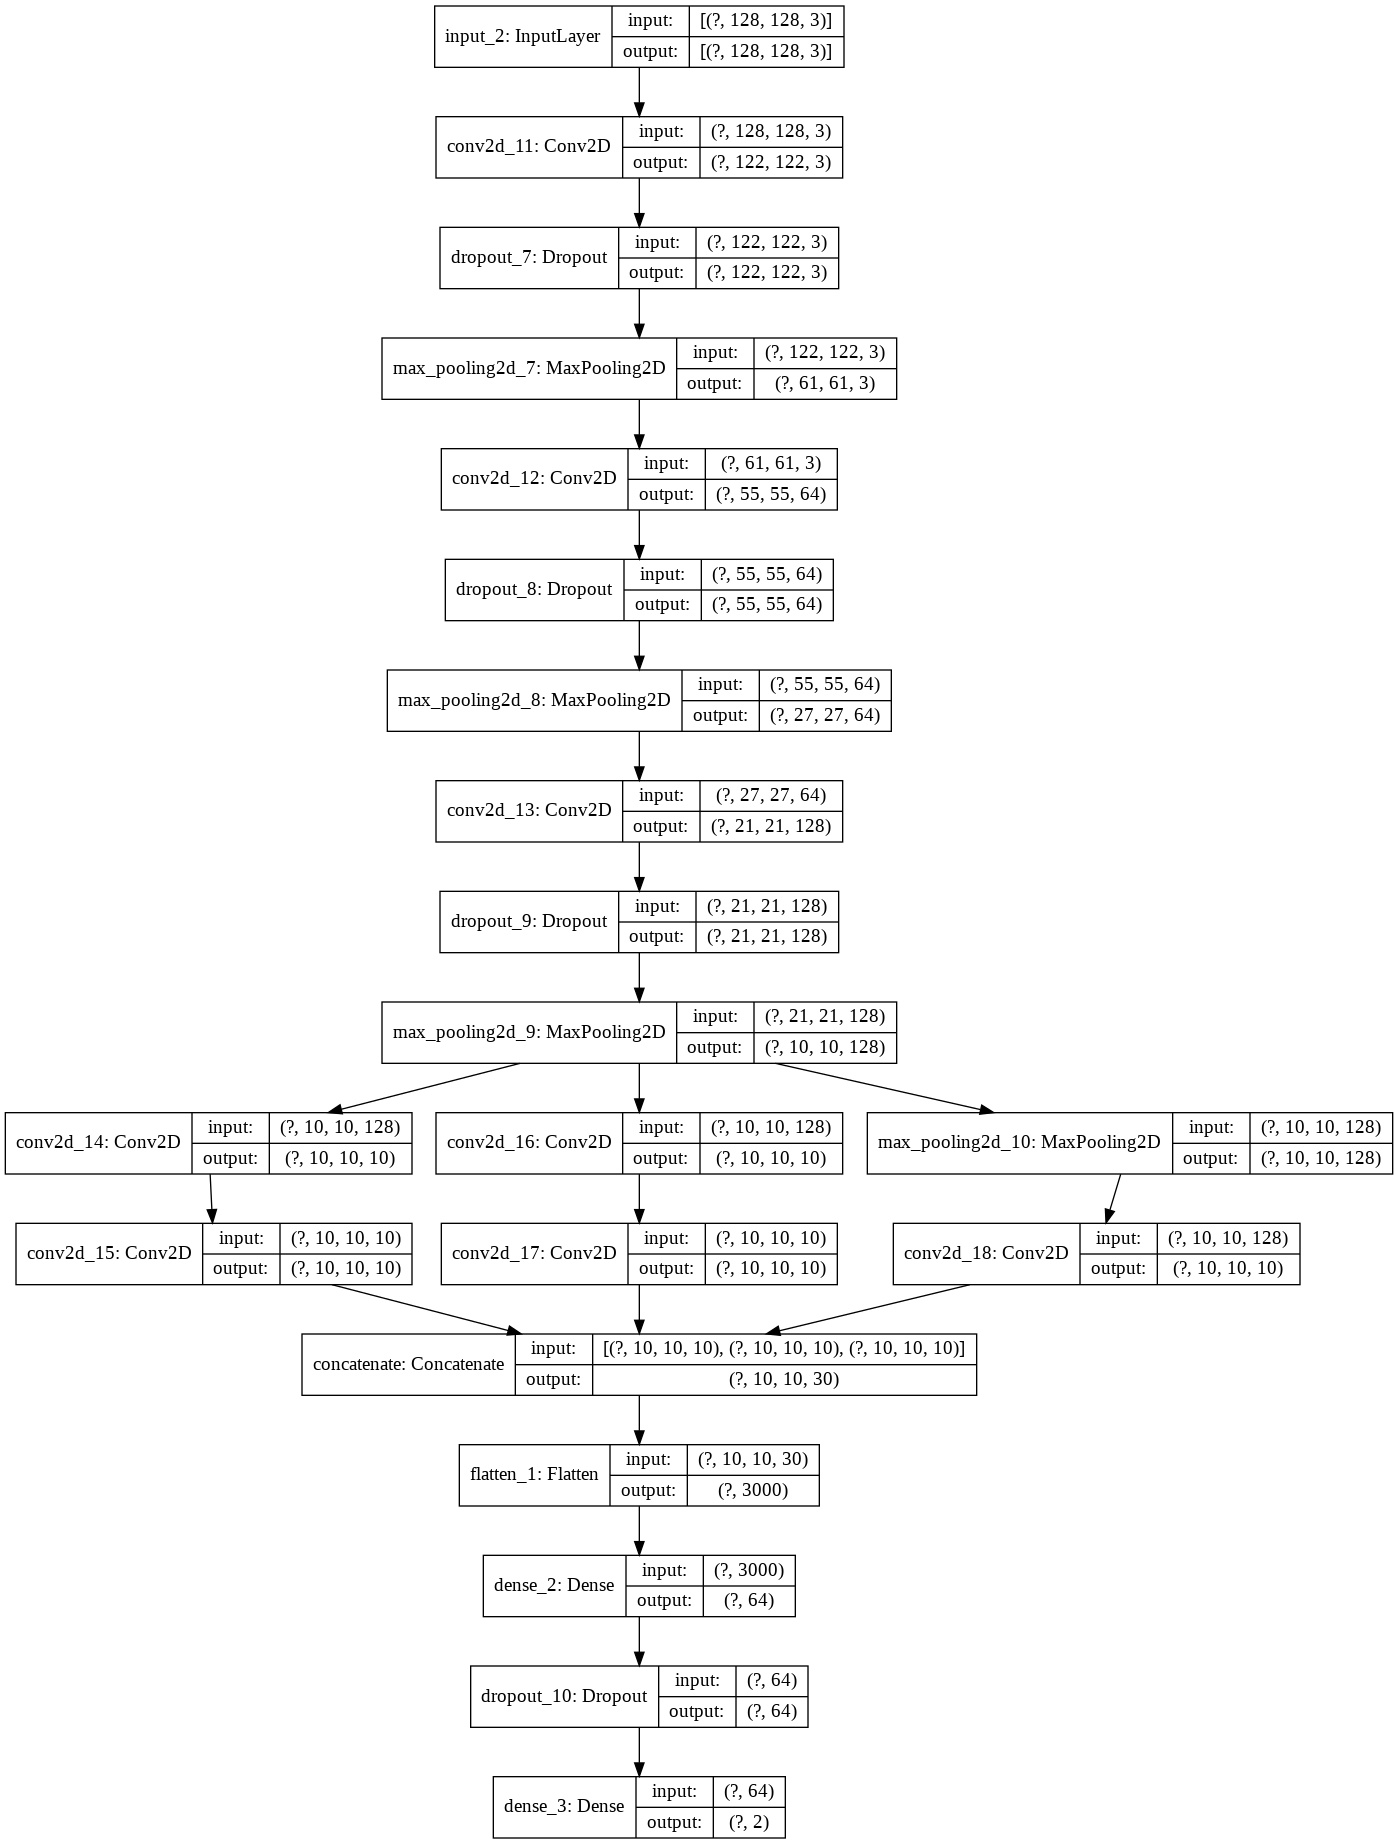

In [18]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Data Augmentation

In [32]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

## Training the Model

In [33]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=8),
               steps_per_epoch=200,
               epochs=100,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.69334, saving model to model.h5
200/200 - 8s - loss: 0.7112 - accuracy: 0.5206 - val_loss: 0.6933 - val_accuracy: 0.4600
Epoch 2/100

Epoch 00002: val_loss improved from 0.69334 to 0.69206, saving model to model.h5
200/200 - 8s - loss: 0.7055 - accuracy: 0.5094 - val_loss: 0.6921 - val_accuracy: 0.4850
Epoch 3/100

Epoch 00003: val_loss improved from 0.69206 to 0.69186, saving model to model.h5
200/200 - 8s - loss: 0.6976 - accuracy: 0.5181 - val_loss: 0.6919 - val_accuracy: 0.4750
Epoch 4/100

Epoch 00004: val_loss improved from 0.69186 to 0.69101, saving model to model.h5
200/200 - 8s - loss: 0.6968 - accuracy: 0.5144 - val_loss: 0.6910 - val_accuracy: 0.5050
Epoch 5/100

Epoch 00005: val_loss improved from 0.69101 to 0.69087, saving model to model.h5
200/200 - 8s - loss: 0.7013 - accuracy: 0.5194 - val_loss: 0.6909 - val_accuracy: 0.5050
Epoch 6/100

Epoch 00006: val_loss improved from 0.69087 to 0.69028, saving model to mode

##Plotting Acc and Loss Plots

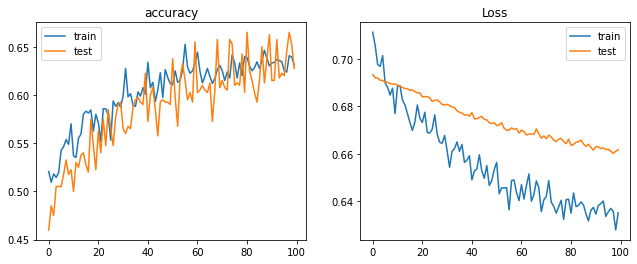

In [34]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.title('accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.title('Loss')
plt.legend()
plt.subplots_adjust(right = 1.5)
plt.show()

## Confusion Matrix

Text(0.5, 145.31999999999996, 'Predicted')

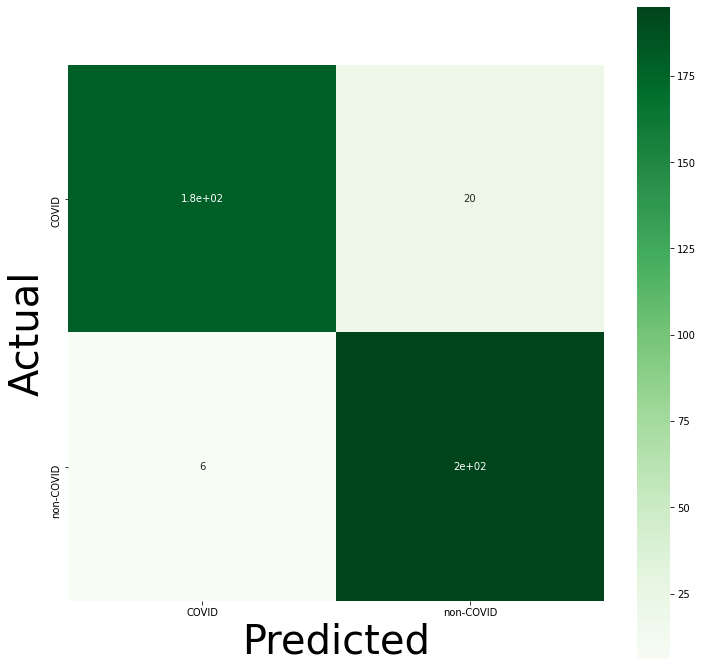

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = classifier.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:

result = classifier.predict(X_val)
r = abs(np.round(result)-Y_val).sum()
(400-r)/400

0.87

In [ ]:
result = classifier.predict(X_train)
r = abs(np.round(result)-Y_train).sum()
(1600-r)/1600

0.88

## Saving Model

In [ ]:
!mkdir -p saved_model
classifier.save('saved_model/my_model') 

In [ ]:
!ls saved_model/my_model

saved_model/my_model


In [ ]:
import tensorflow as tf
from tensorflow import keras
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 122, 122, 32)      4736      
_________________________________________________________________
dropout_9 (Dropout)          (None, 122, 122, 32)      0         
_________________________________________________________________
activation_3 (Activation)    (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 55, 55, 64)        100416    
_________________________________________________________________
dropout_10 (Dropout)         (None, 55, 55, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 27, 64)       

In [ ]:
result = new_model.predict(X_val)
r = abs(np.round(result)-Y_val).sum()
(400-r)/400

0.87

## Saving Model with pythorch

In [ ]:
import torch
from torchvision import datasets, models, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
model_save_name = 'COVID19.h5'
#path = F"/content/gdrive/My Drive/{model_save_name}" 
#torch.save(classifier, path)
classifier.save('/content/gdrive/My Drive/COVID19.h5')